<a href="https://colab.research.google.com/github/FrancescoMorri/Language_Classification/blob/main/notebooks/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

sns.set()

PATH = "/content/drive/MyDrive/language/"

In [ ]:
words = pd.read_csv(PATH+"words_all_unique.csv", usecols=['spelling', 'lexicality'])

# Graphs of Loss and Accuracy

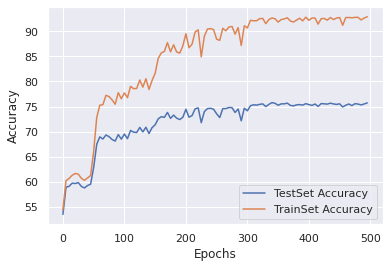

In [46]:
data = np.loadtxt(PATH+"graphs/feed_forward_12chars_MSE_2.csv")
plt.plot(data[:,0], data[:,2], label="TestSet Accuracy")
plt.plot(data[:,0], data[:,3], label="TrainSet Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#plt.yscale("log")
plt.savefig(PATH+"graphs/MSE_12chars_best_2.png", bbox_inches='tight')
plt.show()

# Words analysis with model

## Loading the model

In [34]:
class Words_Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(312, 450)
        self.batch1 = nn.BatchNorm1d(450) 
        self.drop1 = nn.Dropout()
        self.linear2 = nn.Linear(450, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout()
        self.linear3 = nn.Linear(256, 64)
        #self.batch3 = nn.BatchNorm1d(64)
        #self.drop3 = nn.Dropout()
        self.linear4 = nn.Linear(64, 32)
        #self.drop4 = nn.Dropout()
        self.linear5 = nn.Linear(32, 1)

        self.act = nn.ReLU()

    def forward(self, x):
        out = self.linear1(x)
        out = self.drop1(out)
        out = self.batch1(out)
        out = self.act(out)

        out = self.linear2(out)
        out = self.drop2(out)
        out = self.batch2(out)
        out = self.act(out)

        out = self.linear3(out)
        #out = self.drop3(out)
        #out = self.batch3(out)
        out = self.act(out)

        out = self.linear4(out)
        #out = self.drop4(out)
        out = self.act(out)

        out = self.linear5(out)

        return out


In [35]:
net = Words_Net()
net.load_state_dict(torch.load(PATH+"net/feed_forward_12chars_MSE_2", map_location='cpu'))

<All keys matched successfully>

In [36]:
from torchsummary import summary
summary(net, (312,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 450]         140,850
           Dropout-2                  [-1, 450]               0
       BatchNorm1d-3                  [-1, 450]             900
              ReLU-4                  [-1, 450]               0
            Linear-5                  [-1, 256]         115,456
           Dropout-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 64]          16,448
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
             ReLU-12                   [-1, 32]               0
           Linear-13                    [-1, 1]              33
Total params: 276,279
Trainable params:

## Load Dataset Class

In [9]:
from torch.utils.data import Dataset

class WordsDataset(Dataset):

    def __init__(self):
        self.samples = []

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        
        input = self.samples[idx][0]
        label = self.samples[idx][1]
        return input, label
    
    def __addsample__(self, spelling, lexicality, max_length=4):
        if (type(spelling) == type("str")):
            input = torch.tensor(word_to_vec(spelling, max_length=max_length), dtype=torch.float32)
            #check = [False if (i > 1. or i < 0.) else True for i in input]
            #if not all(check):
            #    print("PROBLEM")
            #    print(len(input), spelling)
            if (len(input) > max_length*26):
                print("PROBLEM")
                print(len(input), spelling)
            else:
                # here if it is torch is for the MSELoss, if it is an INT is for the crossentropy
                label = torch.tensor(label_maker(lexicality), dtype=torch.float32)
                #label = label_maker(lexicality)
                self.samples.append([input, label])
        else:
            print("Something Strange:", end='\t')
            print(spelling)

    def __removesample__(self, idx=0, value=None):
        '''
        If value is something, the element corresponding to that value is removed.
        Else the element at index idx is popped.
        '''
        if (value is not None):
            self.samples.remove(value)
        else:
            self.samples.pop(0)
        

In [10]:
trainloader = torch.load(PATH+"trainloader_12chars_MSE.pth")
testloader = torch.load(PATH+"testloader_12chars_MSE.pth")

In [11]:
def vec_to_word(vec):
    word = ""
    for i, a in enumerate(vec):
        if ( a == 1):
            idx = i%26
            char = chr(idx + 97)
            word += char
    return word

In [50]:
data = []
net.eval()
with torch.no_grad():
    for i, tests in enumerate(testloader, 0):
        inputs, labels = tests
        outputs = net(inputs).squeeze()
        #print(outputs.shape, labels.shape, inputs.shape)
        for i,a in enumerate(inputs):
            out = outputs[i]
            lab = labels[i]
            word = vec_to_word(a)
            data.append((word, out, lab))
        

        #squeeze for MSE
        
        #loss = criterion(outputs, labels)
        #loss += loss.item()
        #this for MSELoss
        #predicted = torch.round(outputs)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()

In [18]:
!pip install python-Levenshtein
import Levenshtein as lev

In [56]:
real_w = []
for a in data:
    if (a[2] == 0):
        real_w.append(a[0])

In [60]:
full_data = []
for a in data:
    if (a[2] == 1):
        dist_t = 0
        for w in real_w:
            dist_t += lev.distance(a[0], w)
        dist_t /= len(real_w)

        full_a = a + (dist_t,)
        full_data.append(full_a)
    else:
        full_data.append(a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
